In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import mplhep as hep
import pickle
import pandas as pd
import glob

In [2]:
hep.set_style(hep.style.CMS)

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  """Entry point for launching an IPython kernel.


In [8]:
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector
ak.behavior.update(candidate.behavior)

def getLZDF(f,nEvents=-1,version="new"):
    events_raw = uproot.open(f)['MuonSystem']
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    events = events[start:stop]

    if version=="new":
        events.info=ak.zip({
            "runNum": events.runNum,
            "lumiNum": events.lumiNum,
            "evtNum": events.eventNum,
            }
        )
        events.cls=ak.zip({
            'eta':events.ca4CSCclusterEta,
            'phi':events.ca4CSCclusterPhi,
            'x':events.ca4CSCclusterX,        
            'y':events.ca4CSCclusterY,
            'z':events.ca4CSCclusterZ,                
            'size':events.ca4CSCclusterSize,
            'time':events.ca4CSCclusterTime,
            'timeSpread':events.ca4CSCclusterTimeSpread,            
            "nME11_12": events.ca4CSCclusterME11_12,
            'time':events.ca4CSCclusterTime,            
            "nStation10": events.ca4CSCclusterNstation10,
            "avgStation10": events.ca4CSCclusterAvgStation10,            
            }    
        )
        events.cls_dt=ak.zip({
            'eta': events.ca4DTclusterEta,
            'phi': events.ca4DTclusterPhi,
            'x':   events.ca4DTclusterX,        
            'y':   events.ca4DTclusterY,
            'z':   events.ca4DTclusterZ,                
            'size':events.ca4DTclusterSize,
            'time':events.ca4DTclusterTime,
            "nMB1": events.ca4DTclusterMB1,
            "nMB2": events.ca4DTclusterMB2,            
            "nStation10": events.ca4DTclusterNstation10,
            "avgStation10": events.ca4DTclusterAvgStation10,            
            }    
        )
    return events

# 1. Rate calculation

In [21]:
base = "/uscms/home/kkwok/work/LLP/HLT/v2/CMSSW_12_1_0_pre4/src/RecoMuon/MuonRechitClusterProducer/test/"
dataOld = getLZDF(base+"analyzer_ca4_zerobias_Nov23.root")
# dataNew = getLZDF("../analyzed_L1skim_data.root")
dataNew = getLZDF("./analyzer_ca4_zerobias_Feb14.root")

## 1a) Golden JSON

First, need to make sure the skimmed events are in golden JSON

In [18]:
from coffea import lumi_tools

lumivalues = lumi_tools.LumiData("./lumi2018.csv")

runs  = lumivalues._lumidata[:, 0].astype('u4')
lumis = lumivalues._lumidata[:, 1].astype('u4')

ll = lumi_tools.LumiList(runs,lumis)
# print(lumivalues.get_lumi(ll))


In [32]:
def GetGolden(events,ll):
    skimEvents = np.stack([events.runNum.to_numpy(),events.lumiNum.to_numpy()],axis=1)

    isGolden =np.array([ ak.any(ak.all(np.isin(ll.array,pair),axis=1)) for pair in skimEvents  ])
    return isGolden

## 1b) HLT event selection

In [40]:
def cutFlow_CSCpaths(events,thres=[],isData=False,useFirstCls=False,isGolden=[]):
    if not isData:
        L1 = (events.passL1==1)
        L1cls = events.cls[L1]
    elif len(isGolden)>0:
        if useFirstCls:
            L1cls = ak.firsts(events.cls[isGolden])
        else:
            L1cls = (events.cls[isGolden])
    elif useFirstCls:
            L1cls = ak.firsts(events.cls)
    else:
            L1cls = (events.cls)

    L1cls = L1cls[(L1cls.time<12.5)&(L1cls.time>-5)&(L1cls.nME11_12==0)]

    if not useFirstCls:
        c1 = ak.any((abs(L1cls.eta)<=1.9)&(L1cls.nStation10>=2) & (L1cls.size>=thres[0]),axis=1)
        c2 = ak.any((abs(L1cls.eta)<=1.9)&(L1cls.nStation10<2) & (L1cls.size>=thres[1]),axis=1)
        c3 = ak.any((abs(L1cls.eta)>1.9)&(L1cls.nStation10>=2) & (L1cls.size>=thres[2]),axis=1)
        c4 = ak.any((abs(L1cls.eta)>1.9)&(L1cls.nStation10<2) & (L1cls.size>=thres[3]),axis=1)
    else:
        c1 = ((abs(L1cls.eta)<=1.9)&(L1cls.nStation10>=2) & (L1cls.size>=thres[0]))
        c2 = ((abs(L1cls.eta)<=1.9)&(L1cls.nStation10<2) & (L1cls.size>=thres[1]))
        c3 =( (abs(L1cls.eta)>1.9)&(L1cls.nStation10>=2) & (L1cls.size>=thres[2]))
        c4 =( (abs(L1cls.eta)>1.9)&(L1cls.nStation10<2) & (L1cls.size>=thres[3]))

    if isData:
        eff = len(L1cls[(c1|c2|c3|c4)])
    else:
        eff = len(L1cls[(c1|c2|c3|c4)])/ak.sum(L1)
    mask = (c1|c2|c3|c4)
    return eff,L1cls[(c1|c2|c3|c4)]


def cutFlow_DTpaths(events,thres=[],isData=False,useFirstCls=False,isGolden=True):
    if not isData:
        L1 = (events.passL1==1)
        L1cls = events.cls_dt[L1]
    else:
        if useFirstCls:
            L1cls = ak.firsts(events.cls_dt[isGolden])
        else:
            L1cls = (events.cls_dt[isGolden])  

    if not useFirstCls:
        c1 = ak.any( (L1cls.nMB1==0) & (L1cls.size>=thres[0]),axis=1)
    else:
        c1 = ((L1cls.nMB1==0) & (L1cls.size>=thres[0]))

    if isData:
        if useFirstCls:
            eff = len(cls[~ak.is_none(cls)])
        else:
            eff = len(L1cls[c1])
    else:
        eff = len(L1cls[(c1)])/ak.sum(L1)
    return eff,L1cls[(c1)]

In [43]:
isGoldenNew = GetGolden(dataNew,ll)

In [36]:
isGolden = GetGolden(dataOld,ll)

In [37]:
dataOld

<Array [{runNum: 320570, lumiNum: 381, ... ] type='2645 * {"runNum": uint32, "lu...'>

### Any cluster

In [71]:
import pandas as pd
def printTable(events,normHz,isGolden):
    cols = ["Npass","Rates(Hz)"]

    norm = normHz/sum(isGolden)
    loose,cls  = cutFlow_CSCpaths(events,[100,200,500,500],True,False,isGolden)
    medium,cls = cutFlow_CSCpaths(events,[100,300,500,800],True,False,isGolden)
    tight,cls  = cutFlow_CSCpaths(events,[100,500,500,800],True,False,isGolden)
    DT50,cls  = cutFlow_DTpaths(events,[50],True,False,isGolden)
    DT75,cls  = cutFlow_DTpaths(events,[75],True,False,isGolden)

    table ={}
    table["HLT_CscCluster_Loose_v0"]        =[loose , np.round(loose  *norm,3) ]
    table["HLT_CscCluster_Medium_v0"]       =[medium, np.round(medium *norm,3) ]
    table["HLT_CscCluster_Tight_v0"]        =[tight , np.round(tight  *norm,3) ]
    table["HLT_L1CSCShower_DTCluster50_v0"] =[DT50  , np.round(DT50   *norm,3) ]
    table["HLT_L1CSCShower_DTCluster75_v0"] =[DT75  , np.round(DT75   *norm,3) ]


    df = pd.DataFrame.from_dict(table,orient="index",columns=cols)
    df
    return df

In [73]:
printTable(dataNew,530,isGoldenNew)

,Npass,Rates(Hz)
HLT_CscCluster_Loose_v0,29,3.592
HLT_CscCluster_Medium_v0,18,2.229
HLT_CscCluster_Tight_v0,14,1.734
HLT_L1CSCShower_DTCluster50_v0,2,0.248
HLT_L1CSCShower_DTCluster75_v0,1,0.124


In [72]:
printTable(dataOld,530,isGolden)

,Npass,Rates(Hz)
HLT_CscCluster_Loose_v0,18,4.041
HLT_CscCluster_Medium_v0,9,2.020
HLT_CscCluster_Tight_v0,6,1.347
HLT_L1CSCShower_DTCluster50_v0,0,0.000
HLT_L1CSCShower_DTCluster75_v0,0,0.000


# 2. Signal Efficiency

In [167]:
from signalMap import signalMap

def to_name(s):
    return "_".join(s.split("/")[1].split("_")[1:4])

def getData(signal, hlt_paths):

    events = getLZDF('./signal_eff_Mar/%s.root'%signal)

    csc = ak.any(events.gLLP_csc,axis=1)
    hlt = events.HLT_CscCluster225InTime_v0

    name = to_name(signalMap[signal])

    acc = ak.any(events.gLLP_csc,axis=1)
    CSCorDT = ak.any(events.gLLP_dt,axis=1) | ak.any(events.gLLP_csc,axis=1)    
    DT = ak.any(events.gLLP_dt,axis=1)       
    data = [
        ak.sum(acc)/len(events)    ,  ## CSC acc
        ak.sum(DT)/len(events)     ,  ## DT acc
        ak.sum(CSCorDT)/len(events),  ## CSC|DT acc        
    ]
#     print("acceptance = ",np.round(ak.sum(acc)/len(events),4))    
    for path in hlt_paths:
    #     print(path, "%.4f"%(ak.sum(getattr(events[acc],path))/len(allL1Events)))
        if not "DT" in path:
            data.append(ak.sum(getattr(events[acc],path))/ak.sum(acc))
        else:
            data.append(ak.sum(getattr(events[CSCorDT],path))/ak.sum(CSCorDT))        
    return np.round(np.array(data),4)

In [165]:
to_name(signalMap["signal_11"])

'MH-250_MFF-60_CTau-1000mm'

In [82]:
signal = "signal_11"
events = getLZDF('./signal_eff_Mar/%s.root'%signal)

In [177]:
csc =ak.any(events.gLLP_csc,axis=1)

In [91]:
events.fields

['runNum',
 'lumiNum',
 'eventNum',
 'passL1',
 'processedL1',
 'HLT_DtCluster50_v0',
 'HLT_DtCluster100_v0',
 'HLT_DtCluster50NoVeto_v0',
 'HLT_DtCluster100NoVeto_v0',
 'HLT_CscCluster50InTime_v0',
 'HLT_CscCluster100InTime_v0',
 'HLT_CscCluster150InTime_v0',
 'HLT_CscCluster200InTime_v0',
 'HLT_CscCluster225InTime_v0',
 'HLT_CscCluster50OOT_v0',
 'HLT_CscCluster100OOT_v0',
 'HLT_CscCluster150OOT_v0',
 'HLT_CscCluster200OOT_v0',
 'HLT_CscCluster225OOT_v0',
 'HLT_CscCluster100InTimeNoVeto_v0',
 'HLT_CscCluster_Loose_v0',
 'HLT_CscCluster_Medium_v0',
 'HLT_CscCluster_Tight_v0',
 'HLT_L1CSCShower_DTCluster50_v0',
 'HLT_L1CSCShower_DTCluster75_v0',
 'gLLP_eta',
 'gLLP_phi',
 'gLLP_csc',
 'gLLP_dt',
 'gLLP_beta',
 'gLLP_e',
 'gLLP_pt',
 'gLLP_ctau',
 'gLLP_decay_vertex_r',
 'gLLP_decay_vertex_x',
 'gLLP_decay_vertex_y',
 'gLLP_decay_vertex_z',
 'nca4CSCcluster',
 'ca4CSCclusterSize',
 'ca4CSCclusterX',
 'ca4CSCclusterY',
 'ca4CSCclusterZ',
 'ca4CSCclusterEta',
 'ca4CSCclusterPhi',
 'ca4CSC

In [204]:
events.HLT_CscCluster_Loose_v0==1

<Array [False, False, False, ... False, False] type='10468 * bool'>

In [205]:
events[((events.HLT_CscCluster_Loose_v0==1))].HLT_CscCluster_Loose_v0

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='920 * uint32'>

<Array [[{eta: 2.05, ... avgStation10: 1.99}]] type='721 * var * {"eta": float32...'>

In [164]:
ak.sum(events[ak.any(events.gLLP_csc,axis=1)].HLT_CscCluster_Loose_v0)

721

In [163]:
ak.sum(csc)

1201

In [214]:
hlt_csc = events.cls[csc &(events.HLT_CscCluster_Loose_v0==1)]
events_csc = ak.zip({
    "cls":events.cls[csc]}
)
n,cutFlow_csc = cutFlow_CSCpaths(events_csc,[100,200,500,500],True,False,[])

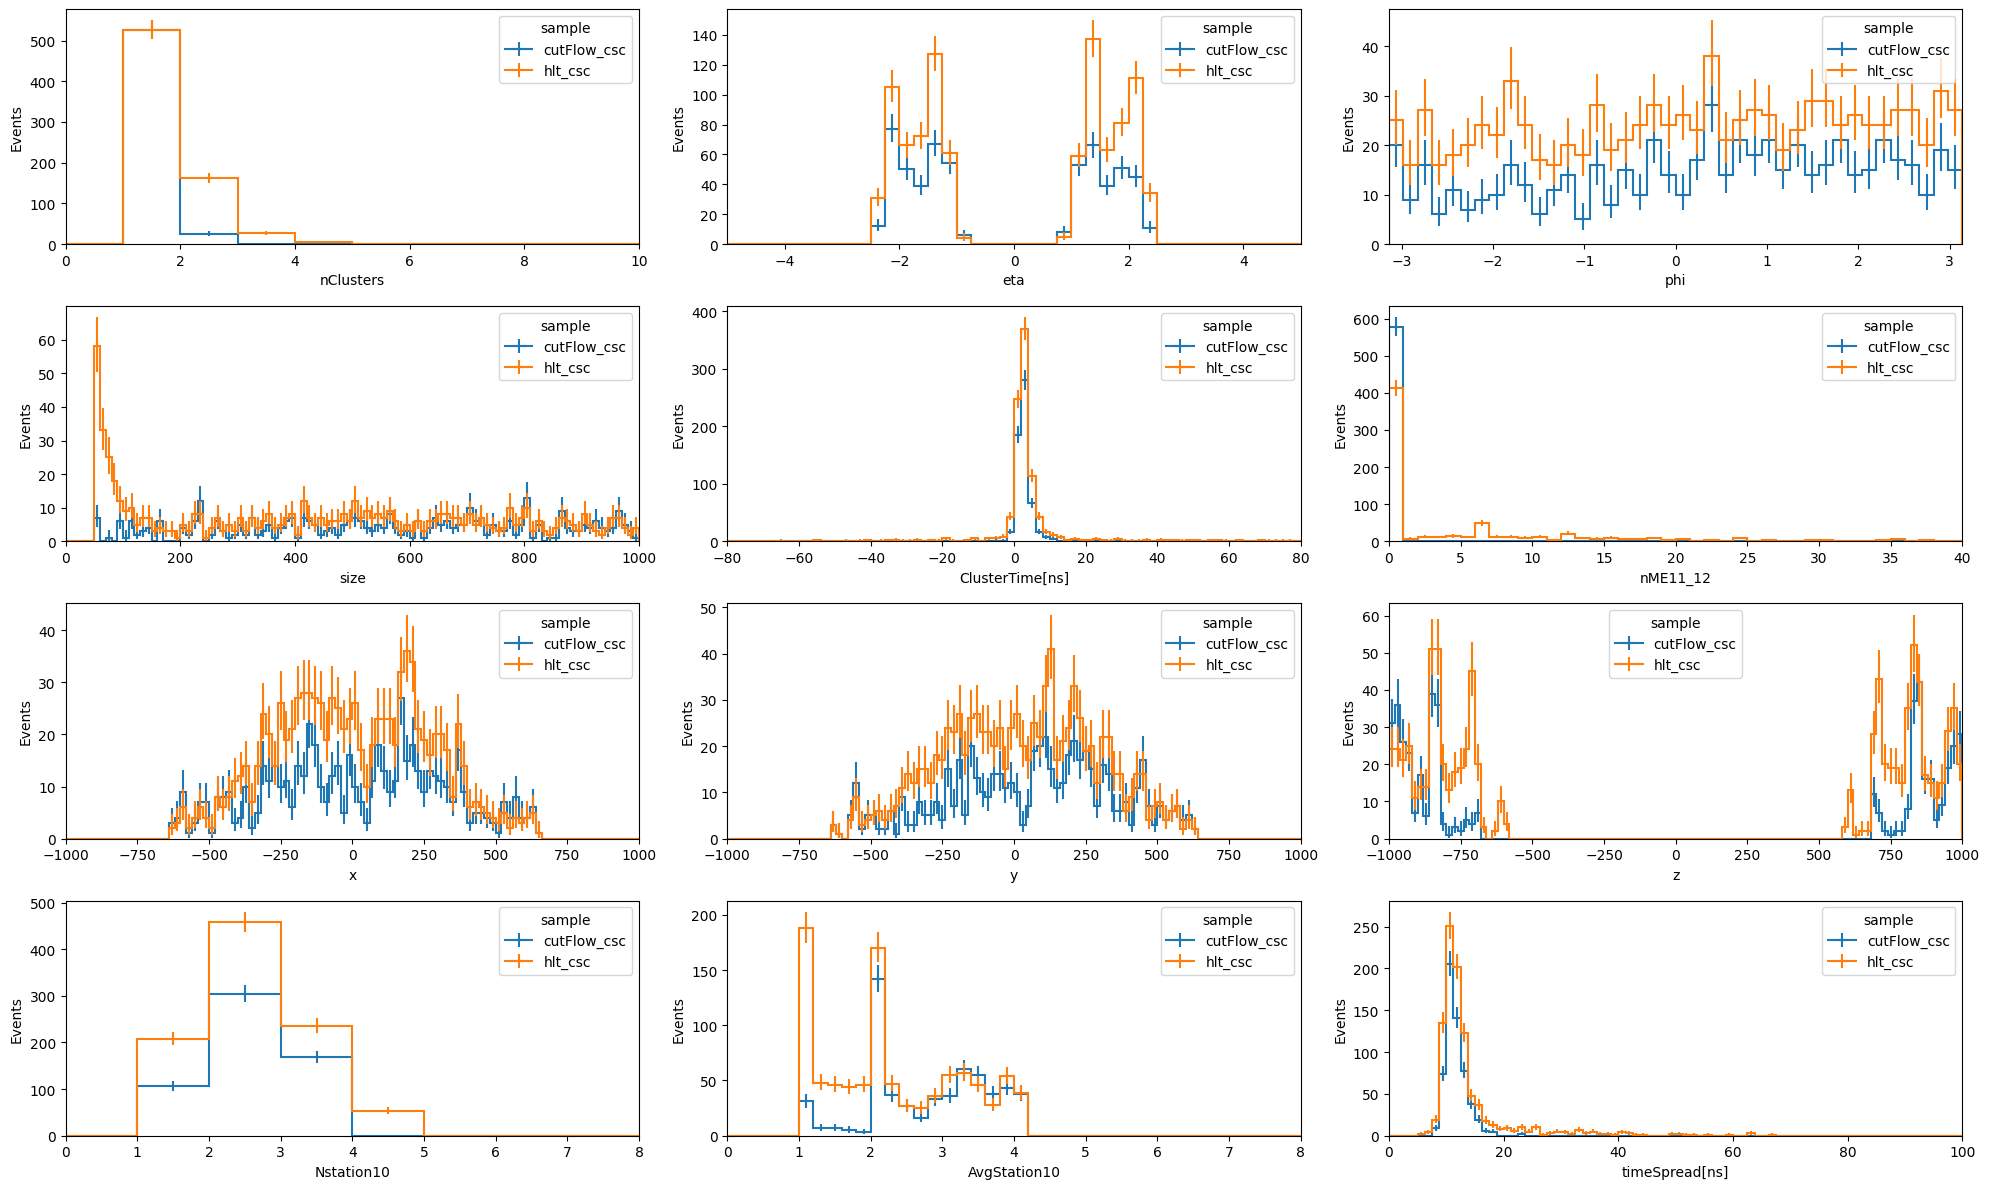

In [215]:
plt.style.use("default")

samples=[
    {"cls":hlt_csc,"label":"hlt_csc"},
    {"cls":cutFlow_csc,"label":"cutFlow_csc"},

]
plotCls(samples,"new",False)

In [166]:
721/1201

0.6003330557868443

In [149]:
csc=ak.any(events.gLLP_csc,axis=1)


In [160]:
events_csc

<Array [[3.21e+03], [3.21e+03, ... [770]] type='1201 * var * float32'>

In [161]:
cutFlow_CSCpaths(events_csc,[100,200,500,500],True,False,[])

(552,
 <Array [[{eta: 2.05, ... avgStation10: 1.09}]] type='552 * var * {"eta": float32...'>)

In [126]:
cutFlow_CSCpaths(events,[100,200,500,500],True,False,[])

(4282,
 <Array [[{eta: 2.05, ... avgStation10: 1.09}]] type='4282 * var * {"eta": float3...'>)

In [145]:
ak.flatten(events.cls[ak.any(events.gLLP_csc,axis=1)]).size

<Array [3.21e+03, 3.21e+03, ... 1.11e+03, 770] type='1588 * float32'>

In [139]:
ak.flatten(events.cls.size)

<Array [2.07e+03, 2.07e+03, ... 770, 770] type='13829 * float32'>

In [140]:
events

<Array [{runNum: 1, lumiNum: 40, ... ] type='10468 * {"runNum": uint32, "lumiNum...'>

(4282,
 <Array [[{eta: 2.05, ... avgStation10: 1.09}]] type='4282 * var * {"eta": float3...'>)

In [168]:
import pandas as pd

hlt_paths = [
 'HLT_CscCluster_Loose_v0',
 'HLT_CscCluster_Medium_v0',
 'HLT_CscCluster_Tight_v0',
 'HLT_L1CSCShower_DTCluster50_v0',
 'HLT_L1CSCShower_DTCluster75_v0', 
]

cols = ["CSC acc.","DT acc.","CSC or DT acc."]+hlt_paths

signals = [
 "signal_3",
 "signal_4",
 "signal_5",
 "signal_6",
 "signal_7",
 "signal_8",
 "signal_11",
 "signal_12",
 "signal_14",
 "signal_15",
#  "signal_18",
 "signal_2",

]
table ={}
for signal in signals:
    table[to_name(signalMap[signal])] = getData(signal,hlt_paths)*100

In [169]:
data = []
m = []
mh = []
ct = []
for k, v in table.items():
    mh.append( int(k.split("_")[0].split('-')[1]))
    m.append(int(k.split("_")[1].split("-")[1]))    
    ct.append(k.split("_")[2].split("-")[1])        
    data.append(v)
    
mi = pd.MultiIndex.from_arrays([mh,m,ct], names=['Higgs Mass', 'LLP mass', 'ctau'])
df = pd.DataFrame(data,index=mi,columns=cols).transpose()
pd.options.display.multi_sparse=False
df = df.sort_index(axis=1,level=[0,1,2])
df = df.style.set_properties(**{'text-align': 'right'})
df

Higgs Mass,125,125,125,125,125,250,250,250,350,350,1000
LLP mass,12,25,25,50,50,60,60,120,160,160,450
ctau,9000mm,15000mm,1500mm,30000mm,3000mm,1000mm,500mm,10000mm,1000mm,500mm,10000mm
CSC acc.,4.98,6.35,16.19,8.03,14.88,11.47,5.56,15.63,2.37,0.42,20.05
DT acc.,6.95,8.04,15.02,6.98,9.47,8.97,2.22,9.37,0.66,0.1,16.55
CSC or DT acc.,11.38,13.56,28.95,14.11,23.1,19.55,7.5,23.58,2.97,0.51,33.86
HLT_CscCluster_Loose_v0,33.79,37.78,42.7,35.1,41.26,60.03,65,34.19,53.49,49.67,57.51
HLT_CscCluster_Medium_v0,30.16,33.49,39.8,32.01,38.61,58.28,65,32.73,52.11,46.41,57.01
HLT_CscCluster_Tight_v0,26.59,28.93,36.59,28.36,36.49,56.54,65,31.48,51.59,46.41,56.39
HLT_L1CSCShower_DTCluster50_v0,0.83,1.49,1.94,1.32,1.37,1.95,0,0.87,0.59,1.08,2.58
HLT_L1CSCShower_DTCluster75_v0,0.64,1.27,1.55,0.97,1.24,1.56,0,0.83,0.59,0.54,2.31


# Rate & eff

In [34]:
events=getLZDF("../signal_7.root")

In [48]:
ak.sum((events.passL1==1)&(ak.any(events.gLLP_csc,axis=1)))/ak.sum(events.passL1==1)

0.9985590778097982

In [ ]:
def cutFlow(events,nHits=50):
    cls = events.cls
    cls = cls[cls.size>=nHits]
    nCls = (ak.num(cls)>=1)
    eta = (abs(cls.eta)<1.9)
#     ME11_12_veto = (cls.nME11+cls.nME12)==0
    ME11_12_veto = (cls.nME11_12)==0    
    time = ((cls.time<12.5) & (cls.time>-5) )
    
    data = []
    data.append(ak.sum(nCls))
    data.append(ak.sum(ak.num(cls[(time)])>=1))    
    data.append(ak.sum(ak.num(cls[(time)&(eta)])>=1))        
    data.append(ak.sum(ak.num(cls[(eta)&(time)&(ME11_12_veto)])>=1))
    for size in [100,150,170,200,225]:
        data.append(ak.sum(ak.sum(cls[(eta)&(time)&(ME11_12_veto)].size>=size,axis=1)>=1))
    return np.array(data)

TypeError: 2645 cannot be converted into an Awkward Array

(https://github.com/scikit-hep/awkward-1.0/blob/1.2.0/src/awkward/operations/convert.py#L1884)

In [95]:
if isGolden:
    print(True)

True


In [330]:
print(cutFlow_CSCpaths(events,[100,200,500,500]))
print(cutFlow_CSCpaths(events,[100,300,500,800]))

print(cutFlow_CSCpaths(events,[100,500,500,800]))

(0.5702449567723343, <Array [[{eta: -1.42, ... avgStation10: 3.24}]] type='1583 * var * {"eta": float...'>)
(0.5223342939481268, <Array [[{eta: -1.42, ... avgStation10: 3.24}]] type='1450 * var * {"eta": float...'>)
(0.4845100864553314, <Array [[{eta: -1.42, ... avgStation10: 3.24}]] type='1345 * var * {"eta": float...'>)


In [84]:
dataOld

<Array [{runNum: 320570, lumiNum: 381, ... ] type='2645 * {"runNum": uint32, "lu...'>

In [79]:
eff,cls=cutFlow_CSCpaths(events,[100,300,500,800])

NameError: name 'events' is not defined

In [104]:
### Any cluster

norm = 530/sum(isGolden)
# norm=1
eff,cls = cutFlow_CSCpaths(dataOld,[100,200,500,500],True,False,isGolden)
print(len(cls[~ak.is_none(cls)])*norm)

eff,cls = cutFlow_CSCpaths(dataOld,[100,300,500,800],True,False,isGolden)
print(len(cls[~ak.is_none(cls)])*norm)

eff,cls = cutFlow_CSCpaths(dataOld,[100,500,500,800],True,False,isGolden)
print(len(cls[~ak.is_none(cls)])*norm)

4.040660736975858
2.020330368487929
1.346886912325286


4.007561436672968
2.2041587901701325
1.4026465028355388


In [47]:
to_name(signalMap["signal_7"])

'MH-125_MFF-50_CTau-3000mm'

In [336]:
eff,cls = cutFlow_DTpaths(dataOld,[0],True,False,isGolden)


In [371]:
cls = dataOld.cls_dt[isGolden]

In [372]:
cls

<Array [[], [], ... []] type='2361 * var * {"eta": float32, "phi": float32, "x":...'>

In [373]:
cls = cls[ak.num(cls)>0]

In [376]:
ak.sum(ak.any((cls.size-cls.nMB1)>100,axis=1))

2

In [378]:
1/sum(isGolden)*530

0.22448115205421432

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation'))

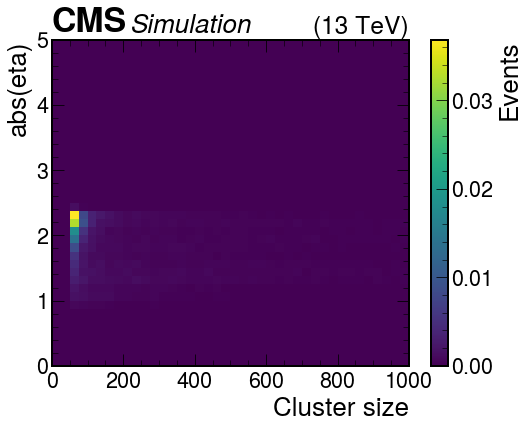

In [55]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
hep.set_style(hep.style.CMS)
h= hist.Hist("Events",
                      hist.Cat("sample","sample"),                      
                      hist.Bin("size", "Cluster size", 40, 0, 1000),
                      hist.Bin("eta", "abs(eta)", 40, 0, 5))


h.fill(sample="signal7",size=ak.flatten(events.cls.size),
                       eta=ak.flatten(abs(events.cls.eta)))
hist.plot2d(h.project("size","eta"),xaxis="size",density=True,ax=ax)
# ax.legend(title="CA(dR=0.4)")
# ax.text(6,0.2,"H->SS->4tau")
hep.cms.label(ax=ax)
# ax.set_ylabel("Density")

## CSC Efficiency

In [32]:
cols = ["nCls>=1","In-time(-5<t<12ns)","abs(eta)<1.9","ME11/12 veto",
        "ClusterSize>=100",
       "ClusterSize>=150",
       "ClusterSize>=170",
       "ClusterSize>=200",
       "ClusterSize>=225"]

ca4_csc = ca4[ak.any(ca4.gLLP_csc,axis=1)]
ca4_csc.cls = ca4.cls[ak.any(ca4.gLLP_csc,axis=1)]
ca3_csc = ca3[ak.any(ca3.gLLP_csc,axis=1)]
ca3_csc.cls = ca3.cls[ak.any(ca3.gLLP_csc,axis=1)]
ca2_csc = ca2[ak.any(ca2.gLLP_csc,axis=1)]
ca2_csc.cls = ca2.cls[ak.any(ca2.gLLP_csc,axis=1)]


norm = 100./len(ca4_csc)
# norm = 1.
table ={}
table["dR=0.2,nHit>50"] =[ "{:.1f} %".format(i) for i in np.round(cutFlow(ca2_csc)*norm,2)]
table["dR=0.3,nHit>50"] =[ "{:.1f} %".format(i) for i in np.round(cutFlow(ca3_csc)*norm,2)]
table["dR=0.4,nHit>50"] =[ "{:.1f} %".format(i) for i in np.round(cutFlow(ca4_csc)*norm,2)]
table["dR=0.4,nHit>100"]=[ "{:.1f} %".format(i) for i in np.round(cutFlow(ca4_csc,100)*norm,2)]

table["factor increase w.r.t. MET200"]=["-","-","-","-"]+\
                                    ["{:.1f}x".format(i) for i in np.round(cutFlow(ca4,100)[4:]*norm/0.32,2)]

df = pd.DataFrame.from_dict(table,orient="index",columns=cols).transpose()
df

NameError: name 'ca4' is not defined

## DT Efficiency

In [127]:
ak.sum(ak.any(ca4_dt.gLLP_dt,axis=1))

1467

In [128]:
cols = ["nCls>=1","MB1 veto",
        "ClusterSize>=100",
       "ClusterSize>=150",
       "ClusterSize>=170",
       "ClusterSize>=200",
       "ClusterSize>=225"]

ca4_dt = ca4[ak.any(ca4.gLLP_dt,axis=1)]
ca4_dt.cls_dt = ca4.cls_dt[ak.any(ca4.gLLP_dt,axis=1)]
ca3_dt = ca3[ak.any(ca3.gLLP_dt,axis=1)]
ca3_dt.cls_dt = ca3.cls_dt[ak.any(ca3.gLLP_dt,axis=1)]
ca2_dt = ca2[ak.any(ca2.gLLP_dt,axis=1)]
ca2_dt.cls_dt = ca2.cls_dt[ak.any(ca2.gLLP_dt,axis=1)]

norm = 100./len(ca4_dt)
# norm = 1.
table ={}
table["dR=0.2,nHit>50"] =[ "{:.1f} %".format(i) for i in np.round(cutFlowDT(ca2_dt)*norm,2)]
table["dR=0.3,nHit>50"] =[ "{:.1f} %".format(i) for i in np.round(cutFlowDT(ca3_dt)*norm,2)]
table["dR=0.4,nHit>50"] =[ "{:.1f} %".format(i) for i in np.round(cutFlowDT(ca4_dt)*norm,2)]
table["dR=0.4,nHit>100"]=[ "{:.1f} %".format(i) for i in np.round(cutFlowDT(ca4_dt,100)*norm,2)]


df = pd.DataFrame.from_dict(table,orient="index",columns=cols).transpose()
df

,"dR=0.2,nHit>50","dR=0.3,nHit>50","dR=0.4,nHit>50","dR=0.4,nHit>100"
nCls>=1,35.1 %,39.9 %,43.1 %,19.9 %
MB1 veto,21.9 %,21.6 %,21.7 %,9.9 %
ClusterSize>=100,9.6 %,9.7 %,9.9 %,9.9 %
ClusterSize>=150,3.6 %,4.7 %,4.5 %,4.5 %
ClusterSize>=170,2.3 %,3.1 %,3.0 %,3.0 %
ClusterSize>=200,1.0 %,1.4 %,1.2 %,1.2 %
ClusterSize>=225,0.6 %,0.6 %,0.4 %,0.4 %


In [32]:
cls = ca4_data.cls

In [110]:
ak.sum(ak.sum(cls[(eta)& (time) &(ME11_12_veto)].size>50,axis=1)>=1)

142

In [37]:
ak.num(cls)

<Array [0, 3, 5, 6, 0, 5, ... 3, 5, 8, 11, 0] type='2645 * int64'>

<AxesSubplot:xlabel='nClusters', ylabel='Events'>

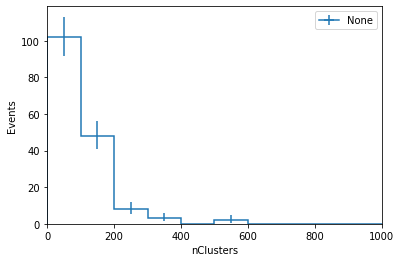

In [64]:
h =hist.Hist("Events",hist.Bin("nClusters", "nClusters", 10, 0, 1000))
h.fill(nClusters = ak.flatten(cls[(eta)& (time) &(ME11_12_veto)].size))
# h.fill(nClusters = ak.num(cls[(eta)& (time) &(ME11_12_veto)]))
hist.plot1d(h)

In [6]:
def match(llp,cls,dR_cut=0.4):
    llp_cls = ak.cartesian({"cls": cls,"llp":llp}, nested=True, axis=1)                
    dR_llp_cls = llp_cls.cls.delta_r(llp_cls.llp)
    dR_matched_llp_cls= ak.values_astype(ak.any(dR_llp_cls<dR_cut,axis=2),np.int)   
    return dR_matched_llp_cls

In [17]:
ca4.cls[matched==0]

<PtEtaPhiMLorentzVectorArray [[], [{pt: 1, ... wireTime: 2.84}], []] type='1478 ...'>

In [66]:
ak.max(ca4.cls.time)

nan

In [170]:
def plotCls(d=[{"cls":"cls","label":"data"}],version="new",density=False):
    
    fig, axs = plt.subplots(4,3,figsize=(20,12))
#     hep.set_style(hep.style.CMS)
    axs = axs.flatten()
    density = density
    h1= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nClusters", "nClusters", 10, 0, 10))
    h2= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("eta", "eta", 40, -5, 5))    
    h3= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("phi", "phi", 40, -np.pi, np.pi))        
    h4= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("size", "size", 100, 0, 1000))        
    h5= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("time", 'ClusterTime[ns]',80, -80, 80))            
    if version=="DT":
        h6 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nMB1", 'nMB1',40, 0, 40))
        h12= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nMB2", "nMB2", 40, 0, 40))        
    else:
        h6 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("nME11_12", 'nME11_12',40, 0, 40))        
        h12= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("timeSpread", "timeSpread[ns]", 80, 0, 100))
        
    h7 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("x", "x", 100, -1000, 1000))        
    h8 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("y", "y", 100, -1000, 1000))        
    h9 = hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("z", "z", 100, -1000, 1000))            
    h10= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("Nstation10", "Nstation10", 8, 0, 8))    
    h11= hist.Hist("Events",hist.Cat("sample","sample"),hist.Bin("AvgStation10", "AvgStation10", 40, 0, 8))    
    
    for sample in d:
        cls = sample['cls']
        label = sample['label']
        h1.fill(sample=label,nClusters=ak.num(cls))
        h2.fill(sample=label,eta = ak.flatten(cls.eta))
        h3.fill(sample=label,phi = ak.flatten(cls.phi)) 
        h4.fill(sample=label,size = ak.flatten(cls.size))
        h5.fill(sample=label,time = ak.flatten(cls.time)) 
        if version=="DT":
            h6.fill (sample=label,nMB1 = ak.flatten(cls.nMB1))        
            h12.fill(sample=label,nMB2 = ak.flatten(cls.nMB2))                
        elif version=="new":
            h6.fill (sample=label,nME11_12 = ak.flatten(cls.nME11_12))
            h12.fill(sample=label,timeSpread = ak.flatten(cls.timeSpread))                
        else:
            h6.fill(sample=label,nME11_12 = ak.flatten(cls.nME11+cls.nME12))        

        h7.fill( sample=label,x = ak.flatten(cls.x))    
        h8.fill( sample=label,y = ak.flatten(cls.y))    
        h9.fill( sample=label,z = ak.flatten(cls.z))        
        h10.fill(sample=label,Nstation10 = ak.flatten(cls.nStation10))            
        h11.fill(sample=label,AvgStation10 = ak.flatten(cls.avgStation10))                
    
    
    hist.plot1d(h1,density=density,ax=axs[0])
    hist.plot1d(h2,density=density,ax=axs[1])
    hist.plot1d(h3,density=density,ax=axs[2])
    hist.plot1d(h4,density=density,ax=axs[3])
    hist.plot1d(h5,density=density,ax=axs[4])
    hist.plot1d(h6,density=density,ax=axs[5])    
    hist.plot1d(h7,density=density,ax=axs[6])    
    hist.plot1d(h8,density=density,ax=axs[7])    
    hist.plot1d(h9,density=density,ax=axs[8])    
    hist.plot1d(h10,density=density,ax=axs[9])    
    hist.plot1d(h11,density=density,ax=axs[10])    
    hist.plot1d(h12,density=density,ax=axs[11])        
    
#     for ax in axs:
#         ax.legend([label])
    plt.tight_layout()
    plt.show()
    

In [17]:
cls = ca4_data.cls
nCls = (ak.num(cls)>=1)
eta = (abs(cls.eta)<1.9)
ME11_12_veto = (cls.nME11_12)==0
time = ((cls.time<12.5) & (cls.time>-5) )
sel =ak.sum(cls[(eta)&(time)&(ME11_12_veto)].size>=225,axis=1)>=1


In [20]:
cls[sel].nStation10

<Array [[1], [1], [1], ... [1], [1, 2], [1]] type='10 * var * int32'>

In [90]:
cls = ca4_data.cls
cls = cls[cls.nME11_12==0]
sel = ak.any(cls.nStation10==4,axis=1) 
zip(ca4_data.runNum[sel],ca4_data.lumiNum[sel],ca4_data.eventNum[sel])

In [75]:
ak.min(cls2.time)

-77.374535

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:753: RuntimeWarning: Allocating a large (>10M bin) histogram!
  warnings.warn("Allocating a large (>10M bin) histogram!", RuntimeWarning)


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Preliminary'))

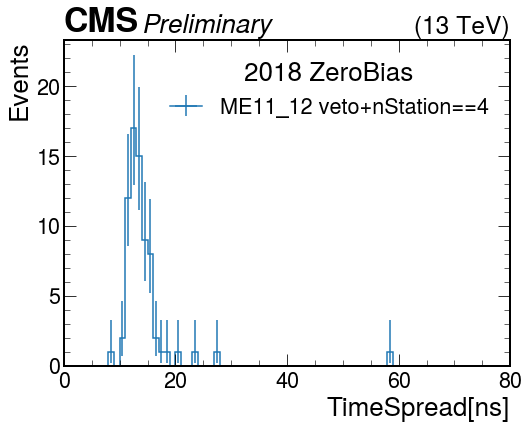

In [116]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
hep.set_style(hep.style.CMS)
h_nCluster= hist.Hist("Events",
                      hist.Cat("sample","sample"),                      
                      hist.Bin('size',"size",1000,0,2000)
                      hist.Bin("nStation10",'nStation10',8, 0, 8),
                      hist.Bin("avgStation10",'avgStation10',8, 0, 8),                      
                      hist.Bin("eta",'eta',20, 0, 3)       
                     )


eta = (abs(ca4_data.cls.eta)<1.9)
ME11_12_veto = (ca4_data.cls.nME11_12)==0
time = ((ca4_data.cls.time<12.5) & (ca4_data.cls.time>-5) )
nstation = (ca4_data.cls.nStation10==4)

cls = ca4_data.cls[(ME11_12_veto)&(nstation)]
h_nCluster.fill(sample="ME11_12 veto+nStation==4",)

hist.plot1d(h_nCluster.project("timeSpread","sample"),density=False,ax=ax)
# hist.plot1d(h_nCluster.project("nStation10","sample"),density=False,ax=ax)
# hist.plot2d(h_nCluster.project("time","nStation10"),density=False,ax=ax,xaxis="time")
# hist.plot2d(h_nCluster.project("eta","nStation10"),density=False,ax=ax,xaxis="eta")
# hist.plot2d(h_nCluster.project("avgStation10","nStation10"),density=False,ax=ax,xaxis="nStation10")
ax.legend(title="2018 ZeroBias")
hep.cms.label(ax=ax,data=True,label="Preliminary")
# ax.set_ylabel("nStation10")


(0.1, 94.48064567003675)

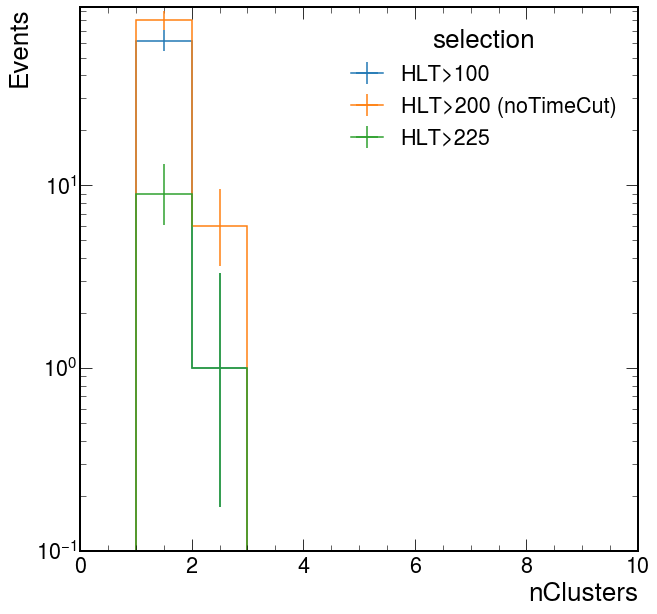

In [30]:
cls = ca4_data.cls
nCls = (ak.num(cls)>=1)
eta = (abs(cls.eta)<1.9)
ME11_12_veto = (cls.nME11_12)==0
time = ((cls.time<12.5) & (cls.time>-5) )
sel =ak.sum(cls[(eta)&(time)&(ME11_12_veto)].size>=225,axis=1)>=1
sel2 =ak.sum(cls[(eta)&(time)&(ME11_12_veto)].size>=100,axis=1)>=1
sel_notime =ak.sum(cls[(eta)&(ME11_12_veto)].size>=200,axis=1)>=1

h= hist.Hist("Events",
             hist.Cat("sel","selection"),
             hist.Bin("nClusters", "nClusters", 10, 0, 10))
h.fill(nClusters=ak.num(cls[sel]),sel="HLT>225")
h.fill(nClusters=ak.num(cls[sel2]),sel="HLT>100")
h.fill(nClusters=ak.num(cls[sel_notime]),sel="HLT>200 (noTimeCut)")
ax = hist.plot1d(h)
ax.set_yscale("log")
ax.set_ylim(1e-1)

In [88]:
data = zip(ca4_data.runNum[sel],ca4_data.lumiNum[sel],ca4_data.eventNum[sel])
for r,l,e in data:
    print("%i:%i:%i"%(r,l,e))

321006:156:281529609
322348:20:1330464
323513:78:55251606
323513:79:56198813
323513:81:59277768
323513:87:66073483
323513:87:65941972
323513:88:66955641
323513:89:67796207
323513:90:68740622
323513:90:68685491
323513:94:72645048
323513:98:76468871
323513:99:76892074
323513:100:78700888
323513:103:81554647
323513:105:84265716
323513:105:84222167
323513:105:84222156
323513:112:92052986
323513:113:92864473
323513:117:96648993
323513:117:97668227
323513:118:98549210
323513:120:100217967
323513:121:101021298
323513:124:105029759
323513:124:105029752
323513:130:111425338
323513:130:110340136
323513:130:110400533
323513:131:112200505
323513:131:112200503
323513:133:113539647
323513:136:117275411
323513:142:122940984
323513:142:122885863
323513:145:126584240
323513:146:127547913
323513:147:128444499
323513:148:129469658
323513:148:130335377
323513:150:132285531
323513:150:132327754
323513:152:134311948
323513:157:139372994
323513:160:142093325
323513:160:142093329
323513:161:143025645
323513:1

In [172]:
cls

<Array [] type='0 * var * {"eta": float32, "phi": float32, "x": float32, "y": fl...'>

AttributeError: no field named 'nME11_12'

(https://github.com/scikit-hep/awkward-1.0/blob/1.2.0/src/awkward/highlevel.py#L1094)

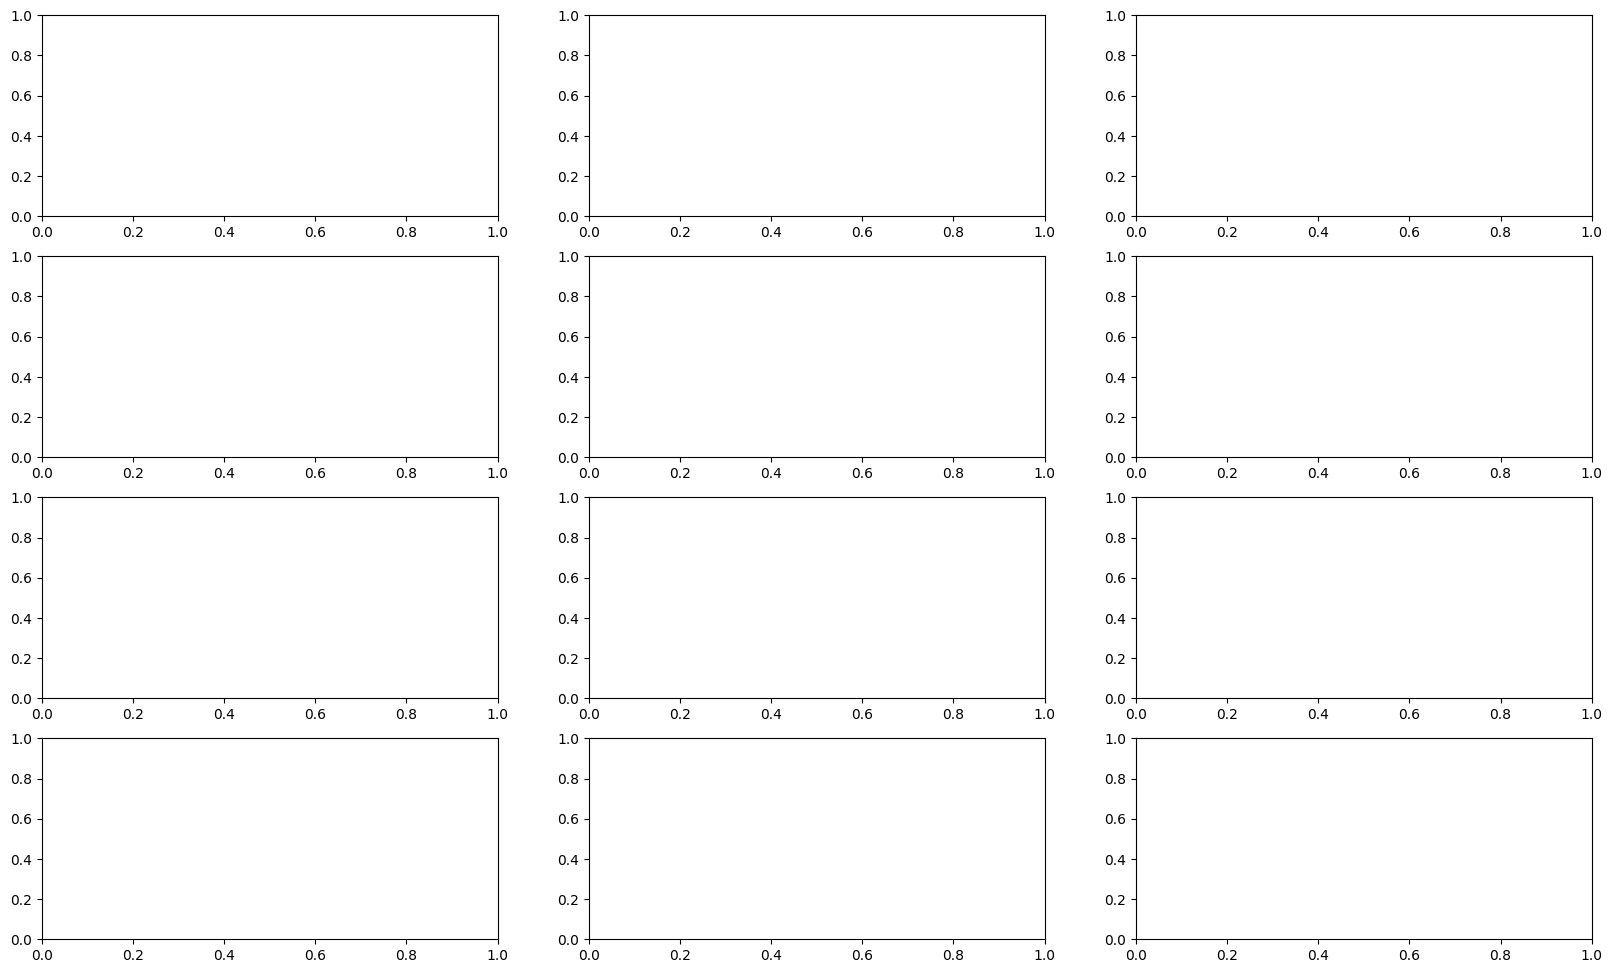

In [171]:
plt.style.use("default")

samples=[
    {"cls":cls,"label":"signal14"},

]
plotCls(samples,"new",False)

# PR validation

In [105]:
# data12X = getLZDF("../analyze_L1oldskim_12X.root")
data12X = getLZDF("../analyze_L1oldskim_12X_full.root")

In [106]:
def Filter(events,thres=[]):
    L1cls = (events.cls)
    L1cls = L1cls[(L1cls.time<12.5)&(L1cls.time>-5)&(L1cls.nME11_12==0)]

    c1 = ak.any((abs(L1cls.eta)<=1.9)&(L1cls.nStation10>1) & (L1cls.size>=thres[0]),axis=1)
    c2 = ak.any((abs(L1cls.eta)<=1.9)&(L1cls.nStation10<=1) & (L1cls.size>=thres[1]),axis=1)
    c3 = ak.any((abs(L1cls.eta)>1.9)&(L1cls.nStation10>1) & (L1cls.size>=thres[2]),axis=1)
    c4 = ak.any((abs(L1cls.eta)>1.9)&(L1cls.nStation10<=1) & (L1cls.size>=thres[3]),axis=1)

    eff = len(L1cls[(c1|c2|c3|c4)])
    mask = (c1|c2|c3|c4)
    return eff,L1cls[(c1|c2|c3|c4)],mask


In [52]:
len(isGolden)

2645

In [53]:
len(data12X[isGolden])

2122

<Array [[], [], ... False, False, False]] type='721 * var * bool'>

In [107]:
norm=1/530
eff,cls,maskLoose = Filter(data12X,[100,200,500,500])
eff,cls,maskMedium = Filter(data12X,[100,300,500,800])
eff,cls,maskTight  = Filter(data12X,[100,500,500,800])
print(ak.sum(maskLoose &(isGolden)))
print(ak.sum(maskMedium &(isGolden)))
print(ak.sum(maskTight &(isGolden)))

20
11
7


In [108]:
HLTLoose=(data12X.HLT_CSCclusterLoose_v0==1) & (isGolden)
HLTMedium=(data12X.HLT_CSCclusterMedium_v0==1) & (isGolden)
HLTTight=(data12X.HLT_CSCclusterTightv0==1) & (isGolden)

print(ak.sum((data12X.HLT_CSCclusterLoose_v0==1) & (isGolden)))
print(ak.sum((data12X.HLT_CSCclusterMedium_v0==1) & (isGolden)))
print(ak.sum((data12X.HLT_CSCclusterTightv0==1) & (isGolden)))

20
11
0


In [109]:
data12X.info[(maskLoose) ].to_list()

[{'runNum': 321475, 'lumiNum': 230, 'evtNum': 323270799},
 {'runNum': 321774, 'lumiNum': 54, 'evtNum': 92599917},
 {'runNum': 321775, 'lumiNum': 26, 'evtNum': 50837178},
 {'runNum': 321004, 'lumiNum': 139, 'evtNum': 184721772},
 {'runNum': 320500, 'lumiNum': 245, 'evtNum': 97038552},
 {'runNum': 323940, 'lumiNum': 831, 'evtNum': 1518897162},
 {'runNum': 324021, 'lumiNum': 207, 'evtNum': 312996162},
 {'runNum': 321119, 'lumiNum': 204, 'evtNum': 252844085},
 {'runNum': 321233, 'lumiNum': 344, 'evtNum': 538234118},
 {'runNum': 321475, 'lumiNum': 89, 'evtNum': 88239275},
 {'runNum': 321233, 'lumiNum': 613, 'evtNum': 962666912},
 {'runNum': 321305, 'lumiNum': 944, 'evtNum': 1522115788},
 {'runNum': 321988, 'lumiNum': 940, 'evtNum': 1659768325},
 {'runNum': 322204, 'lumiNum': 417, 'evtNum': 766726260},
 {'runNum': 322625, 'lumiNum': 170, 'evtNum': 242588470},
 {'runNum': 323513, 'lumiNum': 117, 'evtNum': 96648998},
 {'runNum': 323513, 'lumiNum': 118, 'evtNum': 98549210},
 {'runNum': 323524, 

In [119]:
data12X.info[(data12X.HLT_CSCclusterLoose_v0==1) ].to_list()

[{'runNum': 321475, 'lumiNum': 230, 'evtNum': 323270799},
 {'runNum': 321774, 'lumiNum': 54, 'evtNum': 92599917},
 {'runNum': 321775, 'lumiNum': 26, 'evtNum': 50837178},
 {'runNum': 321004, 'lumiNum': 139, 'evtNum': 184721772},
 {'runNum': 320500, 'lumiNum': 245, 'evtNum': 97038552},
 {'runNum': 323940, 'lumiNum': 831, 'evtNum': 1518897162},
 {'runNum': 324021, 'lumiNum': 207, 'evtNum': 312996162},
 {'runNum': 321119, 'lumiNum': 204, 'evtNum': 252844085},
 {'runNum': 321233, 'lumiNum': 344, 'evtNum': 538234118},
 {'runNum': 321475, 'lumiNum': 89, 'evtNum': 88239275},
 {'runNum': 321233, 'lumiNum': 613, 'evtNum': 962666912},
 {'runNum': 321305, 'lumiNum': 944, 'evtNum': 1522115788},
 {'runNum': 321988, 'lumiNum': 940, 'evtNum': 1659768325},
 {'runNum': 322204, 'lumiNum': 417, 'evtNum': 766726260},
 {'runNum': 322625, 'lumiNum': 170, 'evtNum': 242588470},
 {'runNum': 323513, 'lumiNum': 117, 'evtNum': 96648998},
 {'runNum': 323513, 'lumiNum': 118, 'evtNum': 98549210},
 {'runNum': 323524, 

In [61]:
data12X.info[(maskLoose)& (~HLTLoose) & (isGolden)].to_list()

[]

In [62]:
data12X.cls[(maskLoose)& (~HLTLoose) & (isGolden)].to_list()

[]

In [ ]:
#     c1 = ak.any((abs(L1cls.eta)<=1.9)&(L1cls.nStation10>1) & (L1cls.size>=thres[0]),axis=1)
#     c2 = ak.any((abs(L1cls.eta)<=1.9)&(L1cls.nStation10<=1) & (L1cls.size>=thres[1]),axis=1)
#     c3 = ak.any((abs(L1cls.eta)>1.9)&(L1cls.nStation10>1) & (L1cls.size>=thres[2]),axis=1)
#     c4 = ak.any((abs(L1cls.eta)>1.9)&(L1cls.nStation10<=1) & (L1cls.size>=thres[3]),axis=1)

In [34]:
print(c1[maskLoose][7],
      c2[maskLoose][7],
      c3[maskLoose][7],
      c4[maskLoose][7])

False True False False


In [38]:
print(c1[(maskLoose)& (~HLTLoose) & (isGolden)])
print(c2[(maskLoose)& (~HLTLoose) & (isGolden)])
print(c3[(maskLoose)& (~HLTLoose) & (isGolden)])
print(c4[(maskLoose)& (~HLTLoose) & (isGolden)])

[True, False, False, False, False]
[False, True, False, False, True]
[False, False, True, True, False]
[False, False, False, False, False]


In [112]:
data12X.info[(maskLoose)].lumiNum

<Array [230, 54, 26, 139, ... 48, 441, 186] type='23 * uint32'>

<AxesSubplot:xlabel='lumiNumber', ylabel='Events'>

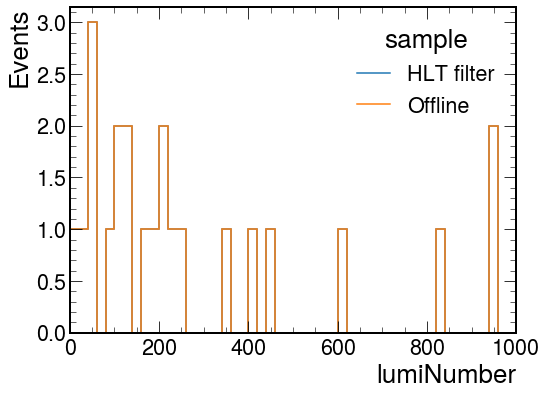

In [122]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
hep.set_style(hep.style.CMS)
h= hist.Hist("Events",
                      hist.Cat("sample","sample"),                      
                      hist.Bin("lumi", "lumiNumber", 50, 0, 1000))


h.fill(sample="Offline",lumi=data12X.info[(maskLoose)].lumiNum)
h.fill(sample="HLT filter",lumi=data12X.info[(data12X.HLT_CSCclusterLoose_v0==1) ].lumiNum)
hist.plot1d(h,ax=ax,line_opts={})
# ax.legend(title="CA(dR=0.4)")
# ax.text(6,0.2,"H->SS->4tau")
# hep.cms.label(ax=ax)
# ax.set_ylabel("Density")